# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 10s 0us/step


In [3]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

Here are some roses:

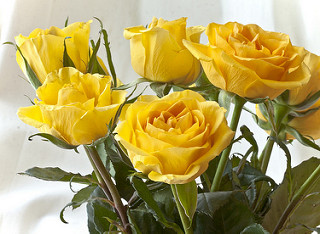

In [4]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

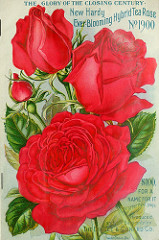

In [5]:
PIL.Image.open(str(roses[1]))

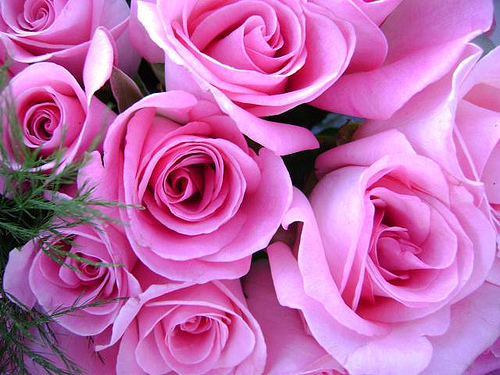

In [6]:
PIL.Image.open(str(roses[2]))

And some tulips:

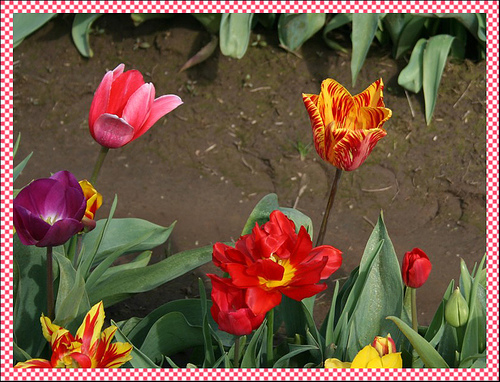

In [7]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

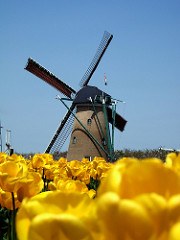

In [8]:
PIL.Image.open(str(tulips[1]))

# Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset`.

## Create a dataset
Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

### Split dataset into train and validation sets

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Visualize the data
Here are the first nine images from the training dataset:

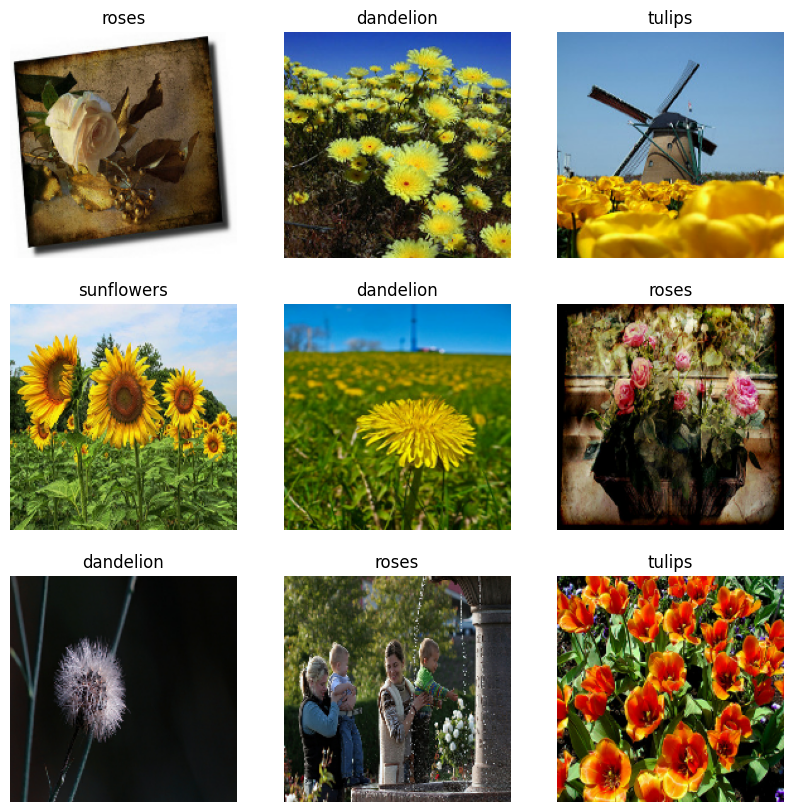

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Configure the dataset for performance




In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Her, you will standardize values to be in the [0, 1] range.

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# A basic Keras model

In [18]:
num_classes = len(class_names)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

# Compile the model

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 118s 1s/step - loss: 1.3841 - accuracy: 0.4128 - val_loss: 1.2027 - val_accuracy: 0.4986
Epoch 2/10
92/92 [==============================] - 110s 1s/step - loss: 1.0702 - accuracy: 0.5862 - val_loss: 1.0655 - val_accuracy: 0.5831
Epoch 3/10
92/92 [==============================] - 111s 1s/step - loss: 0.8822 - accuracy: 0.6672 - val_loss: 0.9108 - val_accuracy: 0.6226
Epoch 4/10
92/92 [==============================] - 113s 1s/step - loss: 0.6430 - accuracy: 0.7681 - val_loss: 0.9341 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 113s 1s/step - loss: 0.4143 - accuracy: 0.8467 - val_loss: 1.0066 - val_accuracy: 0.6676
Epoch 6/10
92/92 [==============================] - 113s 1s/step - loss: 0.2710 - accuracy: 0.9121 - val_loss: 1.1722 - val_accuracy: 0.6689
Epoch 7/10
92/92 [==============================] - 111s 1s/step - loss: 0.1219 - accuracy: 0.9629 - val_loss: 1.3229 - val_accuracy: 0.6499
Epoch 8/10
92

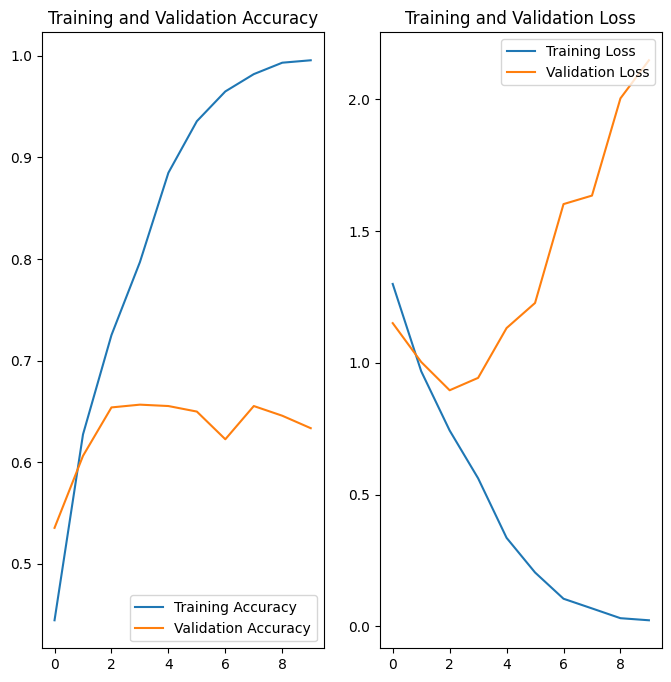

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting

In [23]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),                  
])

Visualize a few augmented examples by applying data augmentation to the same image several times:

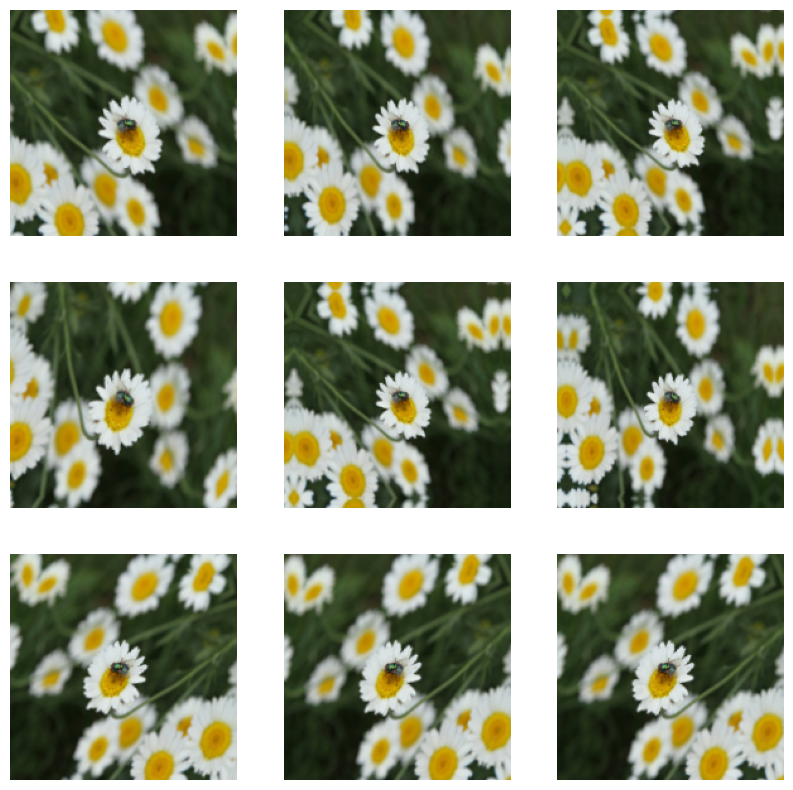

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [28]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax", name="outputs")
])

In [29]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 5s 33ms/step - loss: 1.3552 - accuracy: 0.4009 - val_loss: 1.2414 - val_accuracy: 0.4768
Epoch 2/15
92/92 [==============================] - 3s 28ms/step - loss: 1.1045 - accuracy: 0.5552 - val_loss: 1.1680 - val_accuracy: 0.5422
Epoch 3/15
92/92 [==============================] - 3s 28ms/step - loss: 0.9537 - accuracy: 0.6274 - val_loss: 1.1347 - val_accuracy: 0.5954
Epoch 4/15
92/92 [==============================] - 3s 28ms/step - loss: 0.8613 - accuracy: 0.6683 - val_loss: 0.9842 - val_accuracy: 0.6471
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8003 - accuracy: 0.6911 - val_loss: 0.9288 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 3s 28ms/step - loss: 0.7499 - accuracy: 0.7180 - val_loss: 0.7760 - val_accuracy: 0.7044
Epoch 7/15
92/92 [==============================] - 3s 29ms/step - loss: 0.7272 - accuracy: 0.7214 - val_loss: 0.8700 - val_accuracy: 0.6649
Epoch 8/15
92

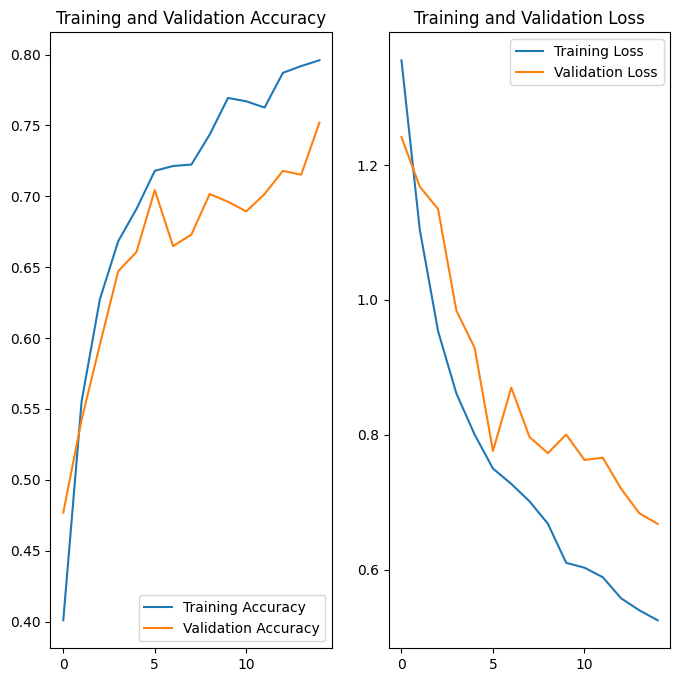

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 534ms/step
This image most likely belongs to sunflowers with a 39.52 percent confidence.


In [33]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [34]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [35]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [36]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite